In [1]:
import os
import numpy as np
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models
import torchvision.transforms as transforms
from misc_functions import preprocess_image, recreate_image, save_image, get_example_params, convert_to_grayscale, save_gradient_images
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 5, 5

## Vanilla gradients visualization

In [6]:
class Vanilla_gradients:
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.model.eval()
        #hook the first layer of the model
        self.hook_layer()
        
    def hook_layer(self):
        
        def hook_fn(module, grad_in, grad_out):
            print("grad_in shape: ", type(grad_in))
            self.gradients = grad_in[0]
            
        self.model.features[0].register_backward_hook(hook_fn)
        
        
    def generate_gradients(self, input_image, output_class):
        
        model_output = self.model(input_image)
        self.model.zero_grad()
        
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][output_class] = 1
        # Backward pass
        #now we want to calculate the gradients of network output wrt to only target class
        model_output.backward(gradient=one_hot_output)
        
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr
        

In [7]:
# Get params
target_example = 1  # cat_dog image
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)
# Vanilla backprop
VBP = Vanilla_gradients(pretrained_model)
# Generate gradients
vanilla_grads = VBP.generate_gradients(prep_img, target_class)
    
# Save colored gradients
save_gradient_images(vanilla_grads, file_name_to_export + '_Vanilla_BP_color')
# Convert to grayscale
grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
# Save grayscale gradients
save_gradient_images(grayscale_vanilla_grads, file_name_to_export + '_Vanilla_BP_gray')
print('Vanilla backprop completed')


grad_in shape:  <class 'tuple'>
Vanilla backprop completed


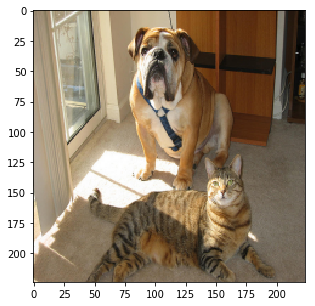

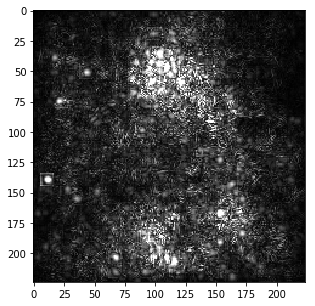

In [8]:
fig = plt.figure()
plt.imshow(original_image)

fig = plt.figure()
plt.imshow(grayscale_vanilla_grads[0], cmap = 'gray')


### Guided backrop

In [53]:
class guided_backprop:
    
    def __init__(self, model):
        
        self.model = model
        self.gradients = None
        self.activations = []
        self.model.eval()
        self.update_relus()
        self.hook_layer()
        
    def hook_layer(self):
        def hook_fn(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        
        first_layer = list(self.model.features)[0]
        first_layer.register_backward_hook(hook_fn)
        
    def update_relus(self):
        
        
        def relu_backward_hook(module, grad_in, grad_out):
            
            #change negative gradient value to zero
            
            activation = self.activations[-1]
            activation[activation > 0] = 1
            modified_grad_out = activation * torch.clamp(grad_in[0], min = 0.0)
            del self.activations[-1]
            return (modified_grad_out,)
            
            
        def relu_forward_hook(module, input, output):
            self.activations.append(input)
            
        #these two updates have to be hook on each layer 
        for layer in list(self.model.features):
            if isinstance(layer, nn.ReLU):
                layer.register_forward_hook(relu_forward_hook)
                layer.register_backward_hook(relu_backward_hook)
        
        
        
    def generate_gradients(self, input_image, label):
        
        output = self.model(input_image)
        self.model.zero_grad()
        
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        one_hot_output[0][label] = 1
        output.backward(gradient=one_hot_output)
        
        return self.gradients.data.numpy()[0]

In [54]:
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Guided backprop
GBP = guided_backprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)

# # Save grayscale gradients
# save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# # Positive and negative saliency maps
# pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
# save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
# save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
# print('Guided backprop completed')

TypeError: '>' not supported between instances of 'tuple' and 'int'